<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo">
</center>

# Understanding  Generative Adversarial Networks GANs

Estimated time needed: **35** minutes

In this lab, we will focus on simulated data to better understand Generative Adversarial Networks (GANs).


## **Table of Contents**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
    </li>
    <li>
        <a href="https://#Background">Background</a>
    </li>
    <li>
        <a href="https://#Toy Data">Toy Data</a>
    </li>
    <li>
        <a href="https://#The Generator">The Generator</a>
    </li>
    <li>
        <a href="https://#The Discriminator">The Discriminator</a>
    </li>
        <li>
        <a href="https://#The Loss Function GANs (Optional)">The Loss Function GANs (Optional)</a>
            <ol>
            <li><a href="https://#Discriminator">Discriminator</a></li>
            <li><a href="https://#Generator">Generator</a></li>
        </ol>
        </li>
    <li>
        <a href="https://#Training GANs">Training GANs</a>
         <ol>
            <li><a href="https://#Training Generator">Training Generator</a></li>
             <li><a href="https://#Training Discriminator">Training Discriminator</a></li>
        </ol>
    </li>


## Objectives

After completing this lab, you will be able to:

*   **Understand** the original formulation of GANs, and their two separately trained networks: Generator and Discriminator
*   **Implement** GANs on simulated and real datasets


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`keras`](https://keras.io/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for loading datasets.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!pip3 install --upgrade tensorflow` in the cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [2]:
%%capture
!pip3 install --upgrade tensorflow

### Importing Required Libraries


In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LVEL'] = '2'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import time
from tensorflow.keras import models
from tqdm import tqdm

### Helper function


In [6]:
def plot_distribution(r_data, g_data, discriminator=None, density=True):
    '''
    r_data = real data
    g_data = generated data
    '''

    # Plot real data
    plt.hist(r_data.numpy(), 100,
            density = density,   # False => counts | True = probability density function (PDF)
            facecolor = 'g',     # data color
            alpha = 0.75,        # transparency
            label = 'real data') # label for legend

    # Plot generated data
    plt.hist(g_data.numpy(), 100,
            density = density,   # False => counts | True = probability density function (PDF)
            facecolor = 'r',     # data color
            alpha = 0.75,        # transparency
            label = 'generated data q(z)') # label for legend

    if discriminator:
        max_ = np.max([int(r_data.numpy().max()), int(g_data.numpy().max())]) # >> 13
        min_ = np.min([int(r_data.numpy().min()), int(g_data.numpy().min())]) # >> 6
        x = np.linspace(min_, max_, 1000).reshape(-1, 1) # shape: (1000, 1)

        # Discriminator line
        plt.plot(x, tf.math.sigmoid(discriminator(x, training=False).numpy()),
                label='discriminator', color='k')

        # 0.5 line
        plt.plot(x, 0.5 * np.ones(x.shape), label='0.5', color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

## Background


Generative Adversarial Networks (GANs) are generative models that convert random samples of one distribution into another distribution. They have several applications, like the following:

*   Generate Examples for Image Datasets
*   Generate Photographs of Human Faces
*   Generate Realistic Photographs
*   Generate Cartoon Characters
*   Image-to-Image Translation
*   Text-to-Image Translation
*   Face Frontal View Generation
*   Generate New Human Poses
*   Face Aging
*   Photo Blending
*   Super Resolution
*   Photo Inpainting
*   Clothing Translation
*   Video Prediction

In this lab, we will use a toy example to help understand the basic theoretical principles behind GANs. The original form of GANs consisted of a discriminator and a generator; let's use the analogy of a currency forger and the police.

The Generator is the currency forger, and the output is the counterfeit, for example, a 100-dollar bill. The discriminator is analogous to the police taking the counterfeit and trying to determine if it's real by comparing it to a real $100 bill. In real life, if the counterfeit is easy to detect, the forger will adapt; conversely, the police will also improve; GANs emulate this game of cat and mouse.

What makes GANs interesting is that the discriminator and generator continuously improve each other by a well-formulated cost function that backpropagates the errors. GANs are a family of algorithms that use *learning by comparison*. In the lab, we will review the original formulation and use a simulated dataset. We will also point you to some more advanced methods and issues you will encounter with the real datasets for the next lab.


<h2 id="about_dataset">Toy Data</h2>

Consider the following data, $\mathbf{x}$, that is normally distributed $\mathbf{x} \sim \mathcal{N}(\mathbf{x}|10,1) $ with a mean of 10 and a standard deviation of 1. Now we would like to randomly sample data from this distribution.


In [7]:
# Generate 5,000 random samples from a Normal (Gaussian) distribution with:
# Mean = 10 and Standard deviation = 1
tf.random.normal((5000, 1), mean=10, stddev=1.0)

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[ 8.754933],
       [ 9.048722],
       [11.414885],
       ...,
       [ 9.196309],
       [10.283933],
       [10.057145]], dtype=float32)>

In [8]:
mean = [10]
conv = [[1]]

# Generate 5,000 random samples from a Normal (Gaussian) distribution with:
# Mean = 10 and Standard deviation = 1
X = tf.random.normal((5000, 1), mean=10, stddev=1.0)

In [9]:
print("Mean value:", np.mean(X))
print("Standard deviation value:", np.std(X))

Mean value: 10.003128
Standard deviation value: 1.0093439


We also have the data sample, z, which is also normally distributed $\mathbf{z} \sim \mathcal{N}(\mathbf{z}|0,2) $, with mean of 0 and a standard deviation of 2:


In [10]:
Z = tf.random.normal((5000, 1), mean=0, stddev=2)
print("Mean value:", np.mean(Z))
print("Standard deviation value:", np.std(Z))

Mean value: 0.023627283
Standard deviation value: 1.9949417


Let's compare the two distributions:


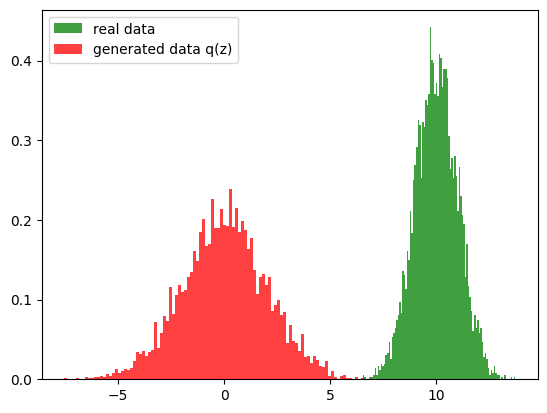

In [11]:
plot_distribution(X, Z, discriminator=None, density=True)

Let's create our first generative model by adding 10 to every sample of $z$. We will call the result $\hat{\mathbf{x}}$  as it's an approximation of $\mathbf{x}$. It is not too difficult to show that $\hat{\mathbf{x}} \sim \mathcal{N}(\mathbf{x}|10,1)$.


In [12]:
Xhat = Z + 10
Xhat

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[ 7.6887627],
       [ 9.607031 ],
       [10.282924 ],
       ...,
       [ 9.996202 ],
       [ 9.252252 ],
       [ 8.696834 ]], dtype=float32)>

We see that the mean and standard deviation are almost identical


In [13]:
print("mean:", np.mean(Xhat))
print("standard deviation:", np.std(Xhat))

mean: 10.023627
standard deviation: 1.9949417


Similarly for the histograms


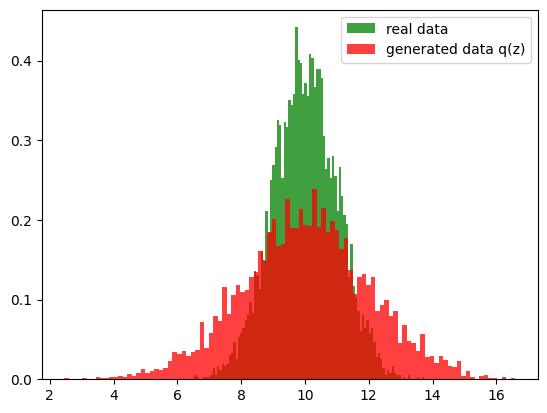

In [14]:
plot_distribution(X, Xhat, discriminator=None, density=True)

In the case above, since we just add 10 to the latent variable $z$, we transform $z$ using a deterministic function. We can call this an implicit generative model.


## The Generator


There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by $G$; the idea is that a neural network can approximate any function (by the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples, $\mathbf{z}$, to one that approximates $\hat{\mathbf{x}}$,  i.e $\hat{\mathbf{x}}=G(\mathbf{z})$. Let's build a simple Generator $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.


In [15]:
def generator_model():
    '''
    This generator takes a single number input and outputs a single number.
    Formula: output = w * Z + b
    '''
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1)) # no activation, linear output
    return generator

We can use the Generator to convert $\mathbf{z}$ and make a prediction $\hat{\mathbf{x}}$, and display the histogram of the distributions of $\hat{\mathbf{x}}$ and $\mathbf{x}$. As the model is not trained, the trained distributions are quite different:


In [16]:
generator = generator_model()
Xhat = generator(Z, training=False)
# NOTE: training=False -> No dropout, no batch norm update (just forward pass)

In [17]:
w, b = generator.layers[0].get_weights()
print("w =", w) # random number
print("b =", b)
print(Z[0])
print(Xhat[0])

w = [[1.300305]]
b = [0.]
tf.Tensor([-2.3112373], shape=(1,), dtype=float32)
tf.Tensor([-3.0053134], shape=(1,), dtype=float32)


In [18]:
# Formula: output = w * Z + b
w * (Z[0]) + 0

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-3.0053134]], dtype=float32)>

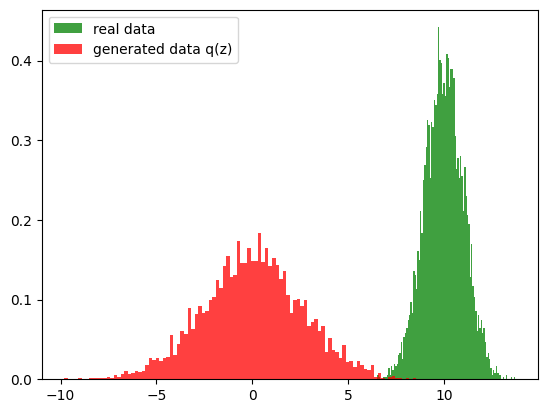

In [19]:
plot_distribution(r_data=X, g_data=Xhat)

We will discuss the use of the parameter `training=False` later on.


## The Discriminator


The discriminator $D(\mathbf{x})$ is a neural network that learns to distinguish between actual and generated samples. The simplest Discriminator is a simple logistic regression function. Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function, which is the convention in Keras.


In [20]:
def discriminator_model():
    '''
    This generator takes a single number input and outputs a single number.
    Formula: output = w * Z + b
    '''
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator = discriminator_model()

The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis. We also include the threshold. If the output of the logistic function is less than 0.5, the sample is classified as generated data; conversely, if the output is greater than 0.5, the sample will be classified as data that came from the real distribution.


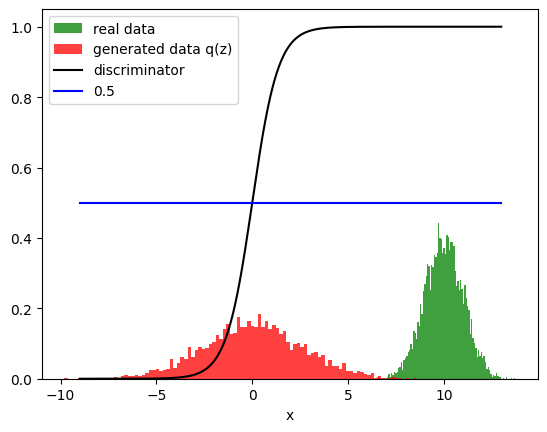

In [21]:
plot_distribution(r_data=X, g_data=Xhat, discriminator=discriminator)

Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:


In [22]:
py_x = tf.math.sigmoid(discriminator(X, training=False))
np.sum(py_x > 0.5)

np.int64(5000)

For the generated data, only 1628 out of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.


In [23]:
py_x = discriminator(Xhat)
np.sum(py_x > 0.5)

np.int64(2280)

We can also use the follwoing to find the average value of the sigmoid function for all the samples.


In [24]:
def get_accuracy(X, Xhat):
    total = 0
    py_x = tf.math.sigmoid(discriminator(X, training=False))
    total = np.mean(py_x)
    py_x = tf.math.sigmoid(discriminator(Xhat, training=False))
    total += np.mean(py_x)
    return total/2

In [25]:
get_accuracy(X, Xhat)

np.float32(0.75264907)

In many cases, we can instead study the difference in the distribution; in this case, the discriminator is called a <a href='https://arxiv.org/pdf/2107.06700.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01'>Critic</a>, a real-valued function.


## The Loss Fuction  GANs (optional)

GANs convert an unsupervised learning problem to a supervised one. Instead of formulating the problem like a two-player minimax game with a value function like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >\[1]</a>, we can treat the problem of maximizing the familiar log-likelihood of the logistic function analogous to minimizing the cross-entropy loss, then incorporate the generator and discriminator.

### Discriminator

In order to train the GANS, we start off with standard maximization of the likelihood for the discriminator for the standard dataset $\mathcal{D}={{(x\_1, y\_1), ..., (x_N, y_N)}}$:

$$V(D)=\sum\_{n=1}^N \left( y_n \ln(D(\mathbf{x}\_n))+(1-y_n) \ln(1-D(\mathbf{x}\_n))\right)$$

Where $y=1$ for samples from the true distribution and $y=0$ for samples from the generator. The goal is to maximize this term with respect to $D$:

$$max\_{D}(V(D))$$


To also incorporate the generated samples, we augment the right side of the equation with the generated $k$th sample $\hat{\mathbf{x}}\_k$. As they are not part of the dataset $k \notin \mathcal{D} $, we have to include a second summation where $y=0$. Finally, combining the cases of $y=1$ and $y=0$, we get:

$$V(D)=\sum\_{ n	\in \mathcal{D}}  \ln(D(\mathbf{x}*n))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(\hat{\mathbf{x}}\_k) ) $$


### Generator

For the generator we simply replace $\hat{\mathbf{x}}\_k$ with the $G(\mathbf{z}\_k)$ .

$$V(G,D)=\sum\_{n	\in \mathcal{D}} \ln(D(\mathbf{x}*n))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}\_k))) $$

As this is a density estimation problem, it is common to replace the summation with the expected value like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >\[1]</a>. We replace the summations with an expectation where $p(\mathbf{x})$ is the true distribution and $p(\mathbf{z})$ is the distribution of $\mathbf{z}$.

$$V(D,G)=\mathbb{E}*{x\sim p(\mathbf{x})} \ln(D(\mathbf{x})) + \mathbb{E}*{\mathbf{z} \sim p(\mathbf{z})} \ln(1-D(G(\mathbf{z}) )) $$

As we are trying to trick the discriminator, we would like to find a $G$ that minimize the above expression, such as:

$$min\_{G} max\_{D} V(D,G)$$


## Training GANS

### Training Generator

GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

$log(1 − D(G(\mathbf{z})))$ is difficult to work with as $D(G(\mathbf{z}))$ is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize $log(D(G(\mathbf{z}\_k)) )$.

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter `training=False` in the actual training steps.

Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

$$\sum\_{k 	\notin \mathcal{D}} log(1 - D(G(\mathbf{z}\_k)) )$$


In [26]:
tf.ones_like(Xhat).shape

TensorShape([5000, 1])

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # use sigmoid function

def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)


### Training Discriminator

We can also use the cross-entropy to train the discriminator; we simply multiply $V(G,D)$ by a negative number, set $y=0$ for the generated values and $y=1$ for the real values. We do not update the generator parameters.

$$V(G)=\sum\_{n	\in \mathcal{D}} (\ln(D(\mathbf{x}*n)))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}\_k) )) $$


The first term is the real loss and the second is the fake loss in Keras.


In [47]:
a = tf.constant([21, 567,-0.5, 2.6])
cross_entropy(tf.ones_like(a), a)

<tf.Tensor: shape=(), dtype=float32, numpy=0.26143041253089905>

In [48]:
def discriminator_loss(X, Xhat):

    # Tell the discriminator that real data should be classified as 1
    real_loss = cross_entropy(tf.ones_like(X), X)

    # Tell the discriminator that fake data should be classified as 0
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)

    # normalizes the loss so that real and fake contributions are balanced
    total_loss = 0.5 * (real_loss + fake_loss)

    return total_loss

We create the optimizer for the discriminator and generator:


In [29]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1, beta_1=0.5, beta_2=0.8)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-1, beta_1=0.5, beta_2=0.8)

We now train the model; as the dataset is small, we will use batch gradient descent.

For each iteration we will generate $M$ real examples ${\mathbf{x}*{1}, ...,\mathbf{x}*{M}}$, these are from the generating distribution $p(\mathbf{x})$. This would be our actual dataset if we used real data.

We will then generate a sample batch of $M$ noise samples ${\mathbf{z}*{1}, ...,\mathbf{z}*{M}}$ from noise prior $p(\mathbf{z})$ and convert the result to a generated image using the generator ${\hat{\mathbf{x}}*{1}, ...,\hat{\mathbf{x}}*{M}}$.

We determine the output of the discriminator for both the real and generated samples. We calculate the loss and then update the discriminator and generator through their respective stochastic gradients.


The convergence of GAN training is a subject in itself. But let's explore a method that works for this simple dataset. Intuitively, we know that if our generated data is identical to our actual data, the probability of correctly classifying is random. Therefore if the generated and actual data are of equal proportion, $D(\mathbf{x}\_n)=0.5$ and $D(\hat{\mathbf{x}}\_n)=0.5$.

We only display iterations where the average discriminator output gets closer to 50% for both the generated data and actual data.


In [54]:
# Parameters for training
EPOCHS = 20
BATCH_SIZE = 5000
NOISE_DIM = 1
EPSILON = 100

In [31]:
# Discriminator and generator
tf.random.set_seed(0)
discriminator = discriminator_model()
generator = generator_model()

tf.config.run_functions_eagerly(True)

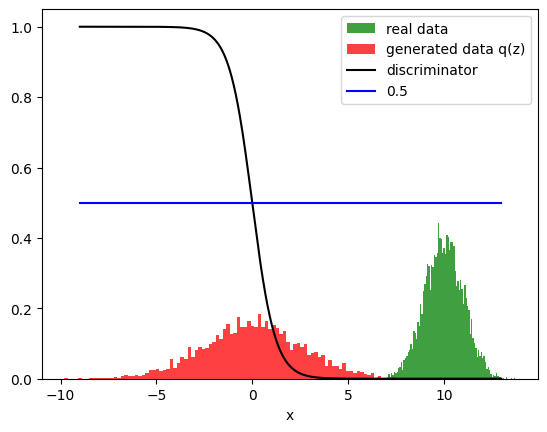

epoch 0


In [32]:
gen_loss_epoch = []
disc_loss_epoch = []
plot_distribution(r_data=X, g_data=Xhat, discriminator=discriminator)
print("epoch", 0)

  0%|          | 0/20 [00:00<?, ?it/s]

0.6149205


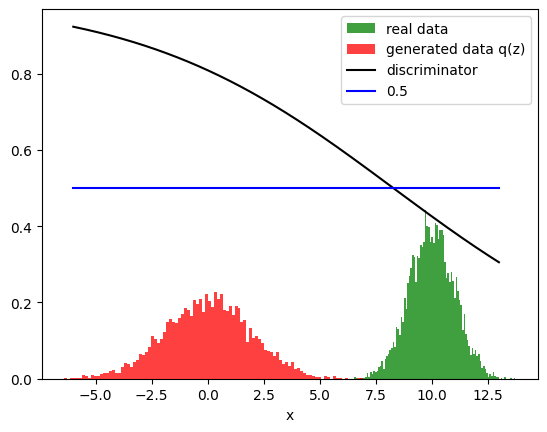

  5%|▌         | 1/20 [00:00<00:09,  1.93it/s]

epoch 0
0.89660054


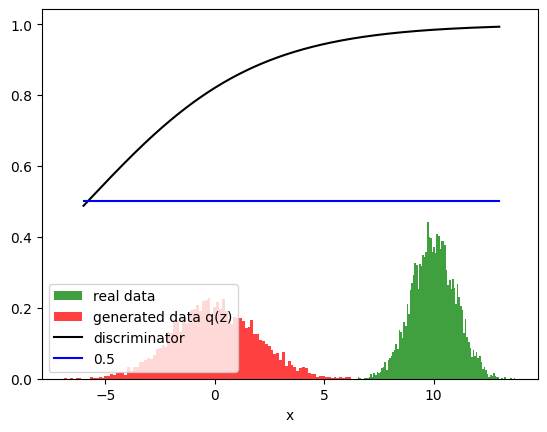

 10%|█         | 2/20 [00:02<00:20,  1.14s/it]

epoch 1
0.86002916


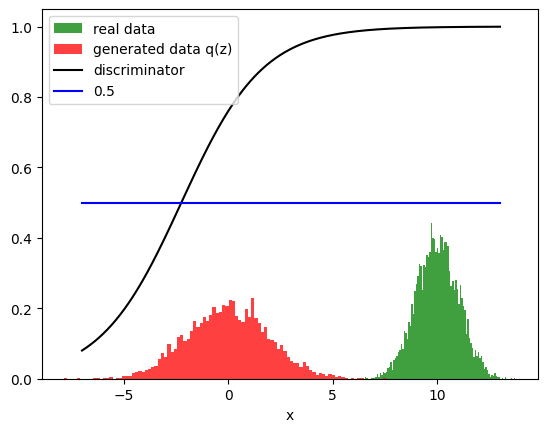

 15%|█▌        | 3/20 [00:02<00:14,  1.16it/s]

epoch 2
0.81462514


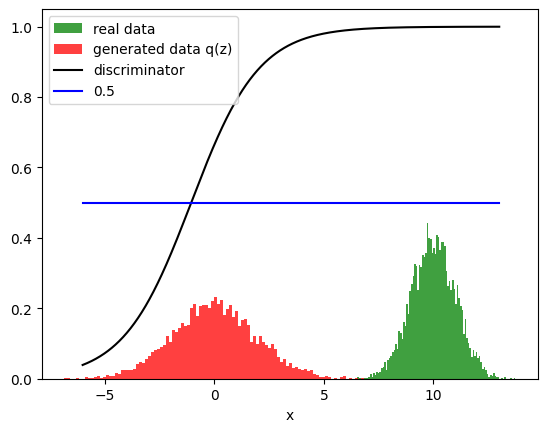

 20%|██        | 4/20 [00:03<00:11,  1.40it/s]

epoch 3
0.7653177


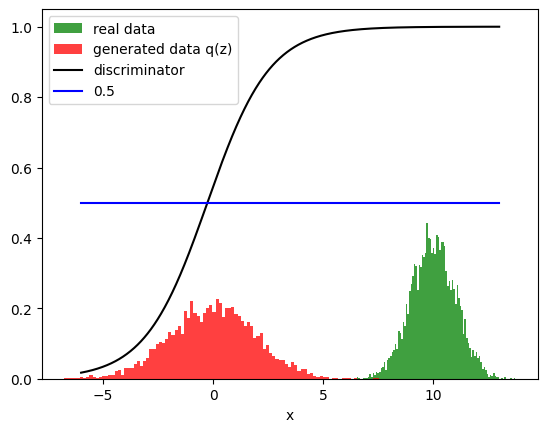

 25%|██▌       | 5/20 [00:03<00:10,  1.49it/s]

epoch 4
0.7221967


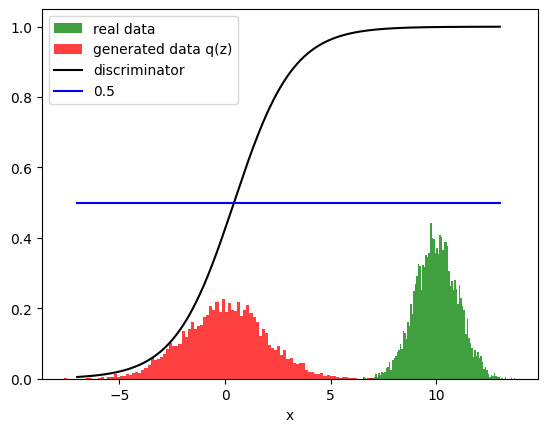

 30%|███       | 6/20 [00:04<00:09,  1.46it/s]

epoch 5
0.67935455


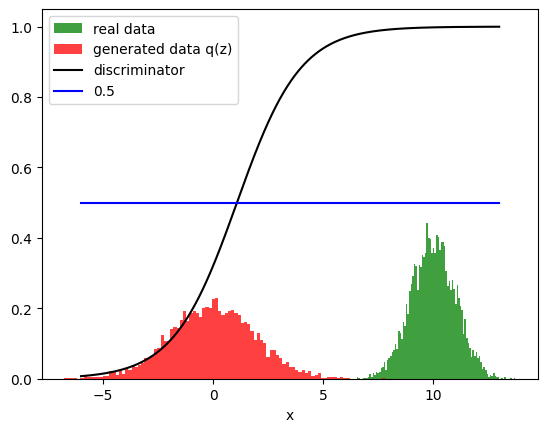

 35%|███▌      | 7/20 [00:05<00:09,  1.41it/s]

epoch 6
0.64253545


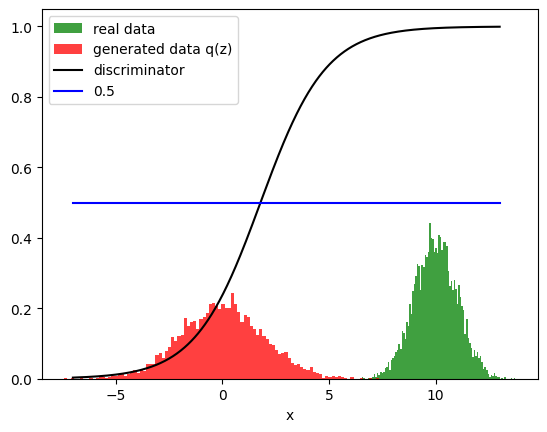

 40%|████      | 8/20 [00:05<00:08,  1.41it/s]

epoch 7
0.6071353


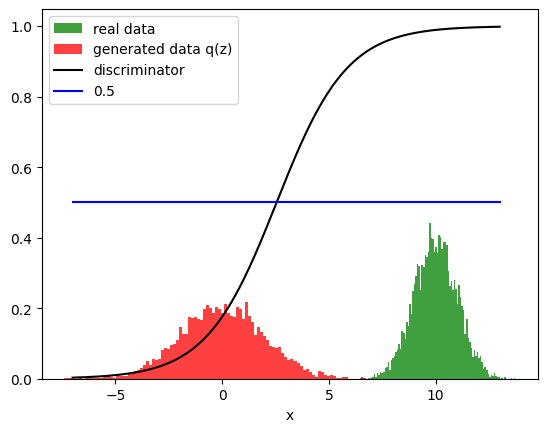

 45%|████▌     | 9/20 [00:06<00:06,  1.59it/s]

epoch 8
0.57462966


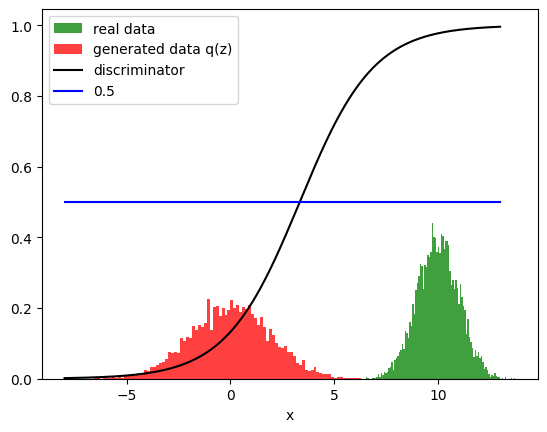

 50%|█████     | 10/20 [00:06<00:05,  1.72it/s]

epoch 9
0.5496572


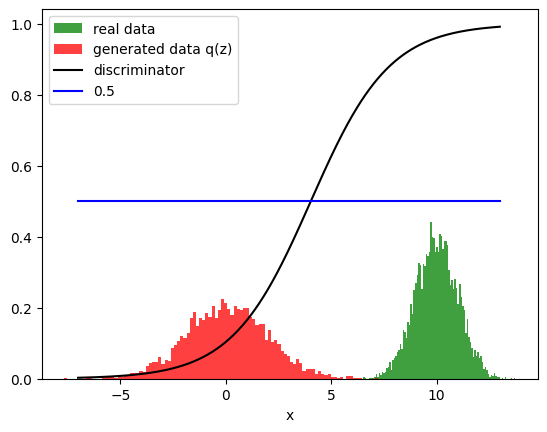

 55%|█████▌    | 11/20 [00:07<00:04,  1.85it/s]

epoch 10
0.5334684


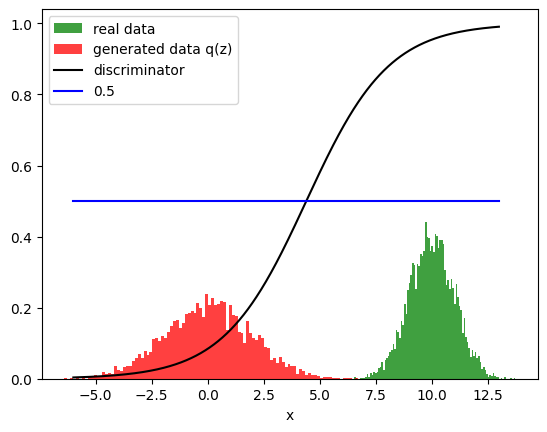

 60%|██████    | 12/20 [00:08<00:05,  1.57it/s]

epoch 11
0.53137803


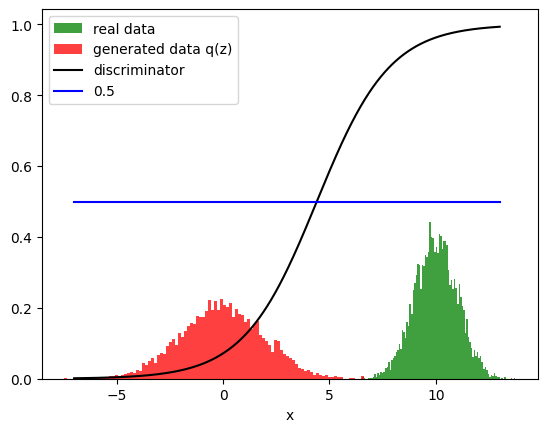

 65%|██████▌   | 13/20 [00:08<00:04,  1.72it/s]

epoch 12
0.53515655


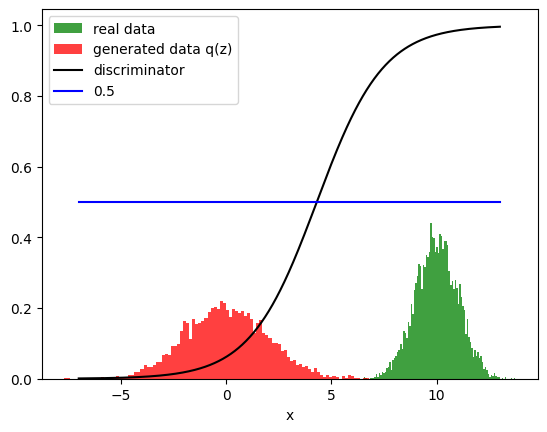

 70%|███████   | 14/20 [00:09<00:03,  1.83it/s]

epoch 13
0.5349783


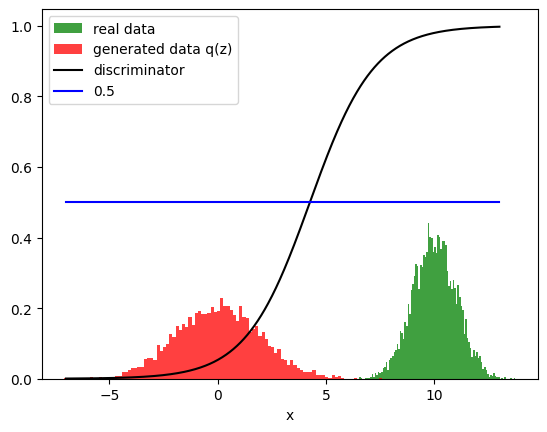

 75%|███████▌  | 15/20 [00:09<00:02,  1.91it/s]

epoch 14
0.53253853


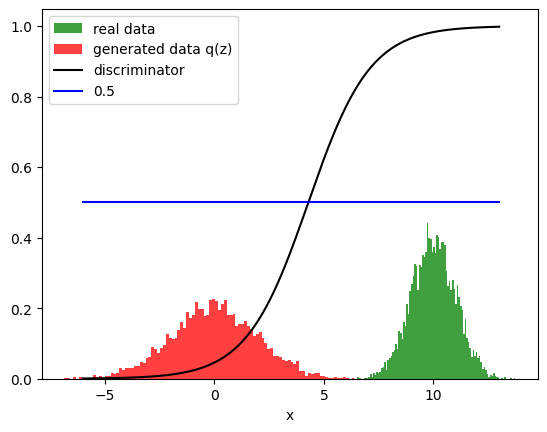

 80%|████████  | 16/20 [00:09<00:02,  1.96it/s]

epoch 15
0.5282006


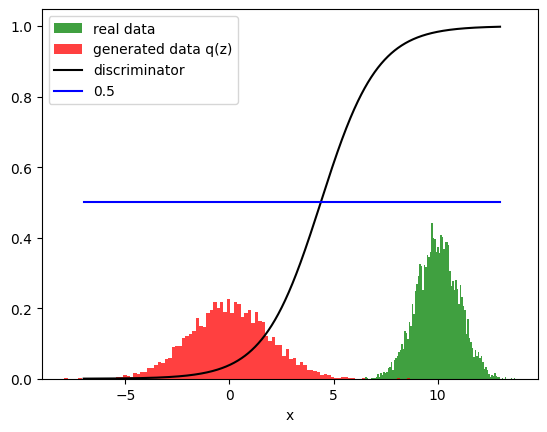

 85%|████████▌ | 17/20 [00:10<00:01,  2.00it/s]

epoch 16
0.5247149


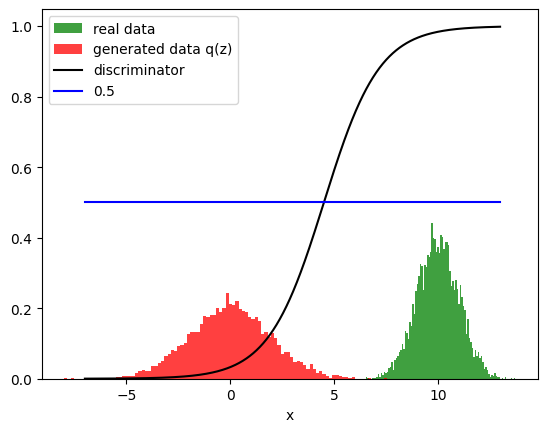

 90%|█████████ | 18/20 [00:10<00:00,  2.06it/s]

epoch 17
0.5206666


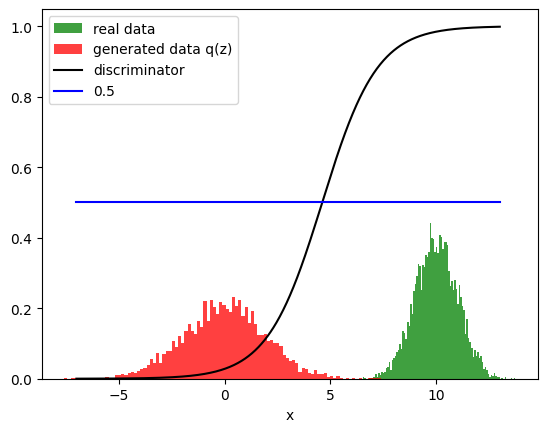

 95%|█████████▌| 19/20 [00:11<00:00,  2.10it/s]

epoch 18
0.51932716


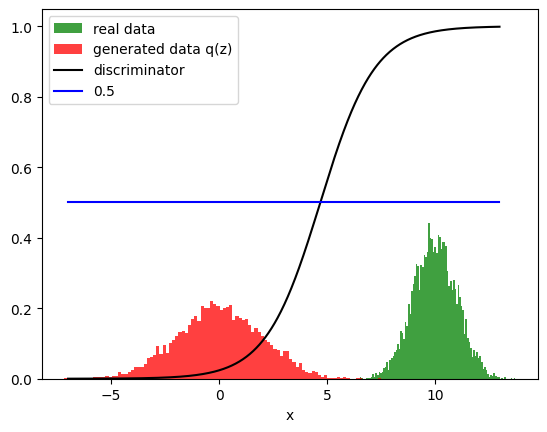

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

epoch 19


In [55]:
for epoch in tqdm(range(EPOCHS)):

    # Generate REAL data sample
    x = tf.random.normal((BATCH_SIZE, 1), mean=10, stddev=1.0)

    # Generate NOISE data sample
    z = tf.random.normal([BATCH_SIZE, NOISE_DIM], mean=0, stddev=10)

    # "GradientTape()"" track computations and calculate gradients automatically
    with tf.GradientTape() as gen_ops, tf.GradientTape() as disc_ops:
        # Run generator model upon noise values to produce fake data
        xhat = generator(z, training=True)
        # Run discriminator model upon real data
        r_output = discriminator(x, training=True)
        # Run discriminator model upon fake data
        f_output = discriminator(xhat, training=True)

        # Calculate generator loss from fake data
        gen_loss = generator_loss(f_output)

        # Calculate discriminator loss between real and fake data
        dis_loss = discriminator_loss(r_output, f_output)


    # Compute derivative of gen_loss with respect to W.
    gradients_generator = gen_ops.gradient(gen_loss, generator.trainable_variables)
    # Returns gradients for all D parameters (W, b, Conv kernels, etc.)
    gradients_discriminator = disc_ops.gradient(dis_loss, discriminator.trainable_variables)

    # Take each gradient and apply it to its matching discriminator weight
    # using the optimizer (Adam).
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator,
                                                discriminator.trainable_variables))
    # NOTE: gradients_discriminator = list of gradients
    #       discriminator.trainable_variables = list of weights

    if abs(0.5 - get_accuracy(x, xhat)) < EPSILON:
        epsilon = abs(0.5 - get_accuracy(x,xhat))
        generator.save('generator.keras')
        discriminator.save('discriminator.keras')
        print(get_accuracy(x, xhat))
        plot_distribution(r_data=X, g_data=xhat, discriminator=discriminator )
        print("epoch", epoch)

For more on training GANs check out the following <a href="https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01">blog</a>. We can display the best performing model


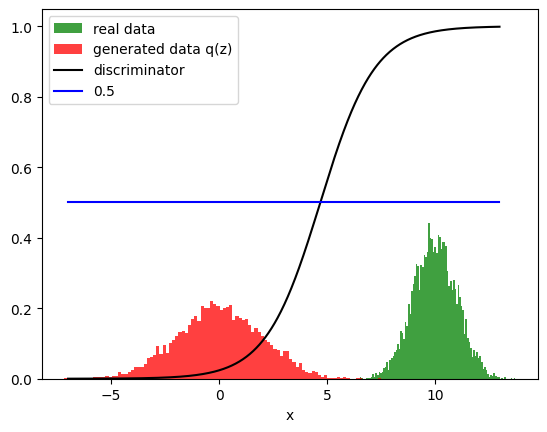

In [56]:
generator = generator_model()
generator = models.load_model('generator.keras')
xhat = generator(z)
discriminator = models.load_model('discriminator.keras')
plot_distribution(r_data=X, g_data=xhat, discriminator=discriminator )

We usually use this version of TensorFlow for the rest of the course, so don't forget to downgrade


In [ ]:
%%capture
!pip install --upgrade tensorflow==1.14.0

**Thank you for completing this lab!**

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

## Change Log

Change Log

| Date (YYYY-MM-DD) | Version | Changed By         | Change Description |
| ----------------- | ------- | ------------------ | ------------------ |
| 2022-06-31        | 0.1     | Joseph Santarcange | Created lab        |
| 2022-09-09        | 0.1     | Steve Hord         | QA pass edits      |

## <h3 align="center"> © IBM Corporation 2022. All rights reserved. <h3/>
